In [1]:
%load_ext autoreload
%autoreload 2

### 1 : Select multiple regions to work with
This can be individual rats, a brain section across a population of rats, or a sections in individual rats. 
Density estimation can be done if the list of region has only one value, and if multiple values, must be the same type of thing

In [2]:
from src.experiments.RatGroup import RatGroup, ALL_RATS, ALL_REGIONS

In [3]:
# Groups represent the unit whose mean density we want to infer. 
# For each group, at least 25 traced images are searched for testing
# Here are some defined RatGroups, but you can define your own!

contralesional_group = RatGroup(rats=ALL_RATS, 
                                regions=["contra_inner", "contra_outer"],
                                group_name = "Contralesional")

ipsilesional_group = RatGroup(rats=ALL_RATS, 
                                regions=["ipsi_inner", "ipsi_outer"],
                                group_name = "Ipsilesional")

superficial_group = RatGroup(rats=ALL_RATS, 
                                regions=["contra_inner", "contra_outer"],
                                group_name = "Superficial Layers")

deeper_group = RatGroup(rats=ALL_RATS, 
                                regions=["ipsi_inner", "ipsi_outer"],
                                group_name = "Deeper Layers")

# To go much more granular, we can have each region be its own group
regions = ["contra_inner", "contra_outer", "ipsi_inner", "ipsi_outer"]
single_region_groups = [RatGroup(rats=ALL_RATS, regions=reg, group_name=reg) for reg in regions]

In [4]:
# And here are some potential comparisons using these groups
# groups = single_region_groups
# groups = [superficial_group, deeper_group]
groups = [contralesional_group, ipsilesional_group]

# and define group labels for the pipeline (for graphs mostly)
group_labels = [group.group_name for group in groups]

In [5]:
# STEP 1 - SET EXPERIMENT PARAMETERS

debug_mode = False
level_for_this_experiment = 2

from src.utils.traceProps import get_axon_count, get_mean_axon_length, get_trace_density

# ground_truth_functions = [get_axon_count, get_mean_axon_length, get_trace_density]
# propery_names = ["Axon Count", "Mean Axon Length", "Axon innervation density"]
ground_truth_functions = [get_trace_density]
propery_names = ["Axon innervation density"]

unlabeled_dir = r".\data\project_scans"
train_write_path = r".\data\tracings\rat301_train"
test_dataset_path = r".\data\tracings\rat301_test"

img_input_size = 128
from src.experiments.InferencePipeline import InferencePipeline
pipe = InferencePipeline(groups, img_input_size,
                         og_path = unlabeled_dir, train_path=train_write_path, test_path=test_dataset_path, 
                         group_labels = group_labels, 
                         ground_truth_functions=ground_truth_functions, propery_names=propery_names,
                         debug_mode=debug_mode)

Real density mean in group Contralesional : 0.01034271240234375, Std for group is : 0.009924845987526977
Real density mean in group Ipsilesional : 0.0109539794921875, Std for group is : 0.005619082285154225
U statistic: 972.5
p-value: 0.05616781166357616
No significant difference in means.
----------------------------------------
Real density mean in group Contralesional : 0.0097760009765625, Std for group is : 0.008585335903941864
Real density mean in group Ipsilesional : 0.0122589111328125, Std for group is : 0.007859859566321226
U statistic: 975.5
p-value: 0.05889978169352182
No significant difference in means.


np.float64(0.05889978169352182)

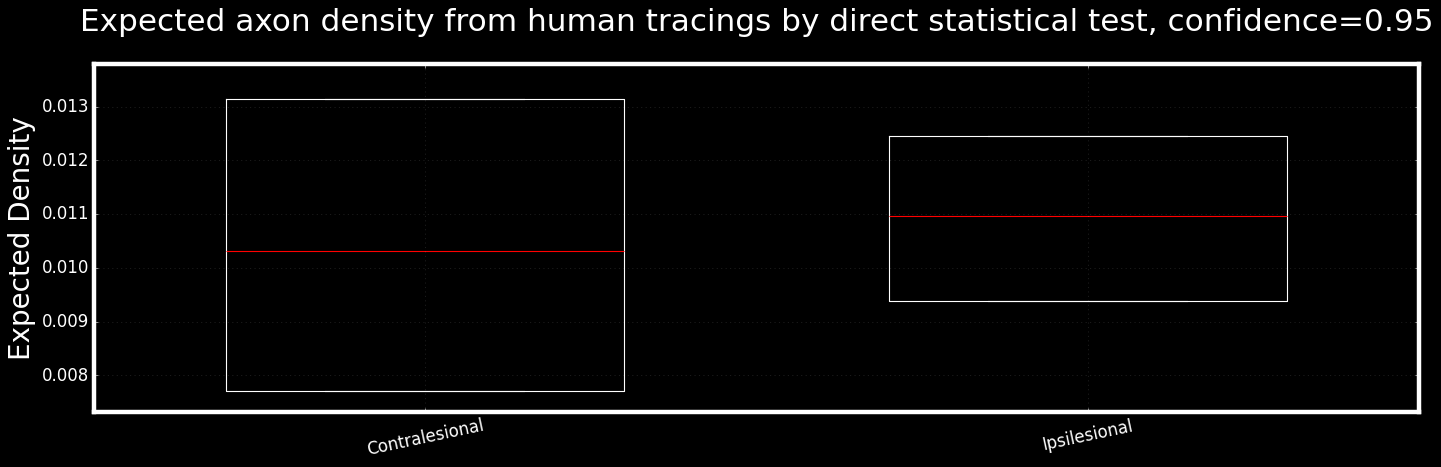

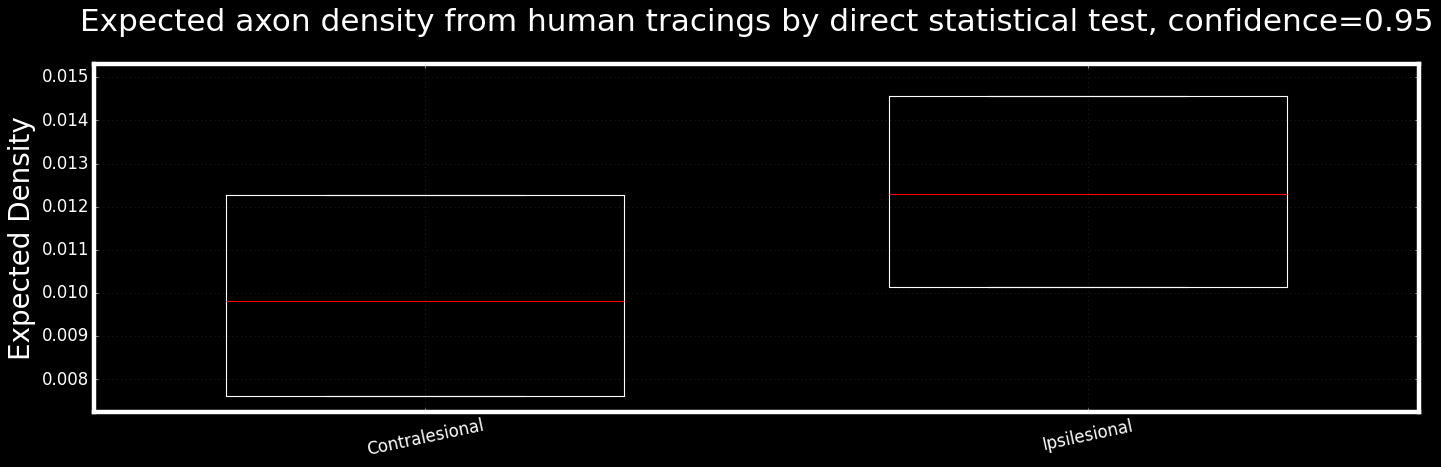

In [6]:
# STEP 1.5 quick checks on tracings density with a statistical test
from src.dataprep.TracingChecker import TracingChecker
checker = TracingChecker(train_write_path)
checker.statistical_test_between_groups(groups, get_trace_density, group_labels=group_labels)

print("-" * 40)
checker = TracingChecker(test_dataset_path)
checker.statistical_test_between_groups(groups, get_trace_density, group_labels=group_labels)

# print(*checker.get_img_paths_from_region_group(["ipsi_outer"]), sep="\n")

### 2 : Load training and testing images for the regions of interest
Data for training may be diverse and has less limitations. Testing data must be randomly distributed sections of the regions we care about.
Existing datasets should be searched for existing labels. If no more than 25 labels exist, the user should be prompted to create a dataset and label more regions 
before continuing.

In [7]:
# STEP 2 - LOAD EXPERIMENT DATA
pipe.load_data()

### 3 : Train models on the training data (if not loaded pretrained)
It should be possible to train the same models on different datasets and use them differently during evaluation

In [8]:
# STEP 2 - Train models
pipe.make_models()
pipe.train_models()

### 4 : Evaluate the models on all regions of interest seperately, select the best model for each region
Differents lists of density estimation models can be passed to each evaluation of the regions of interest. The best model for inference should be the one that minimizes RMSE or something.

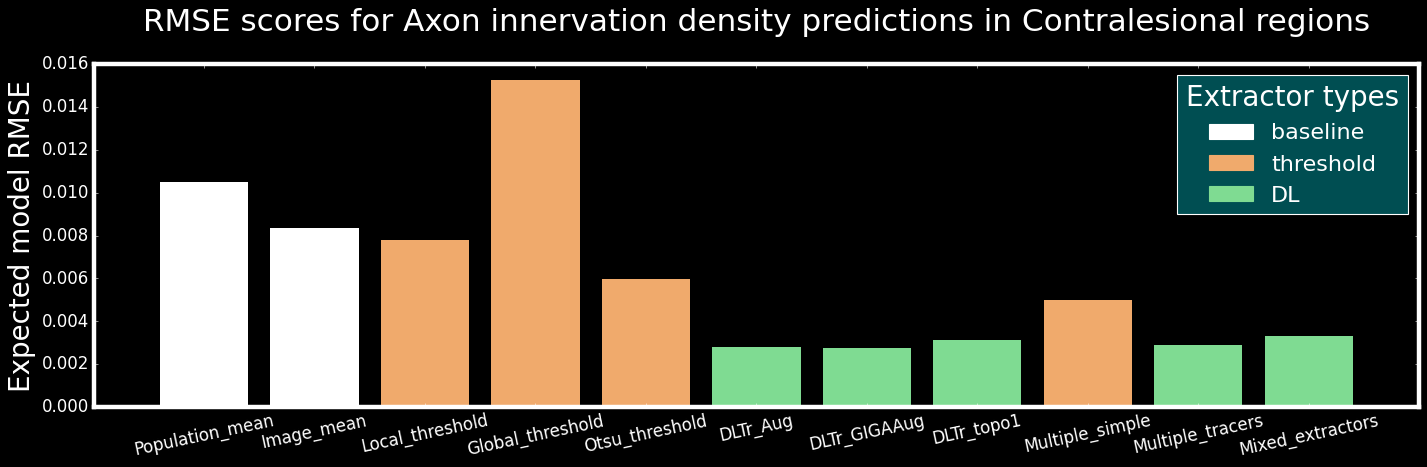

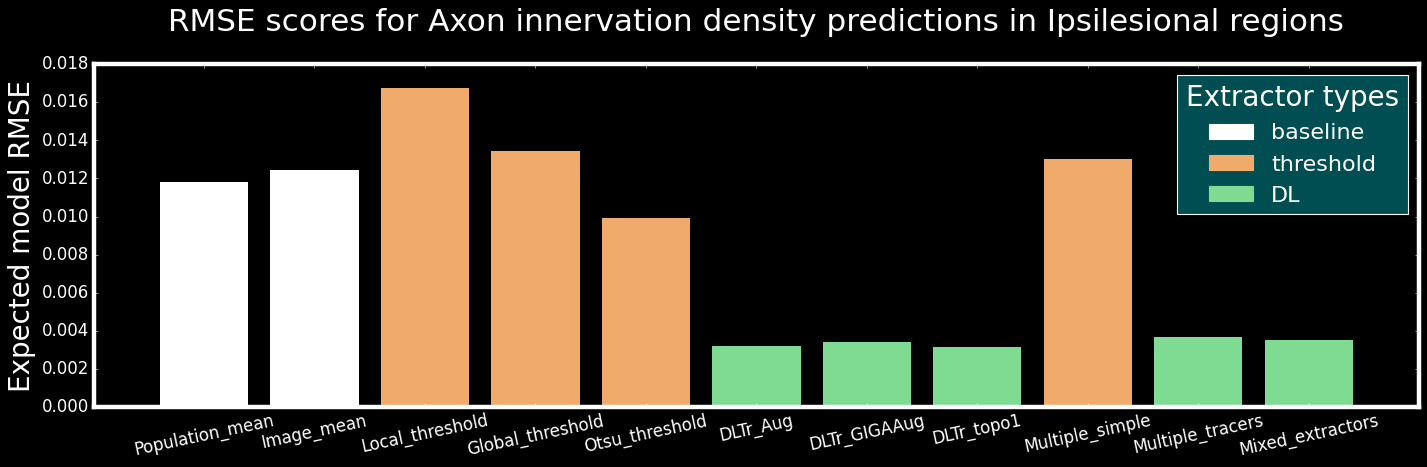

In [10]:
# STEP 4 - EVALUATE EACH MODEL IN EACH GROUP ON ITS TEST DATASET FOR MODEL SELECTION
pipe.evaluate_models(display_model_performances=True, n_bootstraps_trials=50)
pipe.select_best_models()

### 5 For each selected model, deduce the RMSE on the region it is attributed to
A RMSE estimator can be inferred from the model's RMSE on the test set, with bootstrapping to evaluate the upper and lower bound on that RMSE

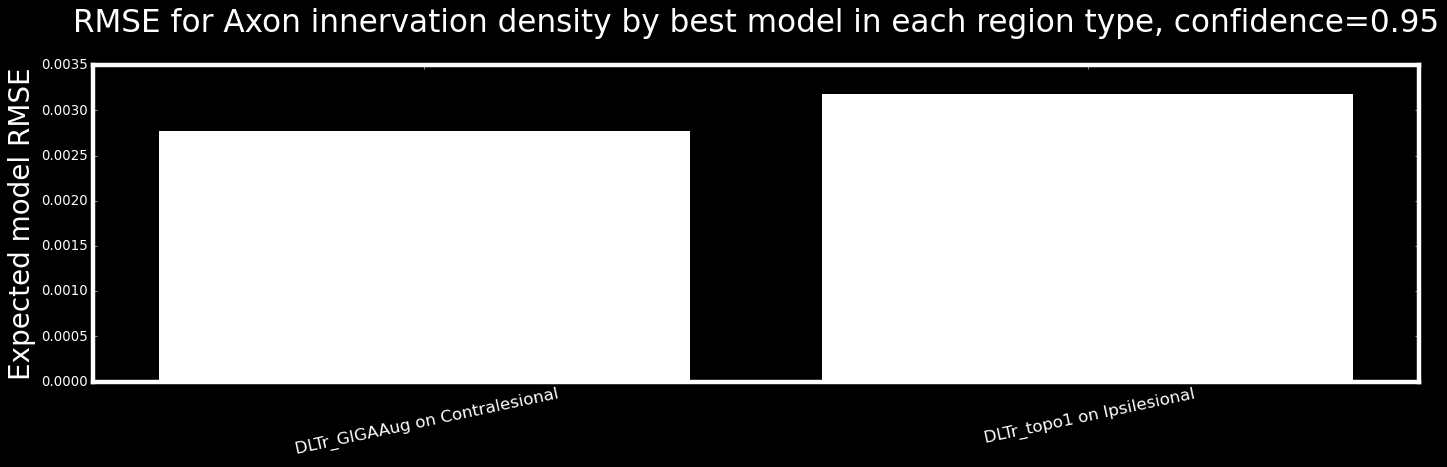

In [ ]:
# STEP 5 - DEDUCE RMSE ON MODELS - not correct, replaced with model-based estimation approach
pipe.calculate_model_uncertainty(n_bootstrap=500)

### 6 Infer with each model on their regions of interest, and deduce the lower and upper bound for density in that region from the deduced RMSE for that model
Assuming model bias is approximately 0, we use the inferred region density mean and the CLT to deduce the expected density in that region and confidence intervals over the density

In [11]:
# STEP 6 - INFER ON THE REGIONS WE CARE ABOUT - not correct, replaced with model-based estimation approach
pipe.infer_mean_region_density_in_groups()

ValueError: max() arg is an empty sequence